In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.1" 2018-10-16 LTS; OpenJDK Runtime Environment Zulu11.2+3 (build 11.0.1+13-LTS); OpenJDK 64-Bit Server VM Zulu11.2+3 (build 11.0.1+13-LTS, mixed mode)
  Starting server from /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbtc23rlz
  JVM stdout: /tmp/tmpbtc23rlz/h2o_ec2_user_started_from_python.out
  JVM stderr: /tmp/tmpbtc23rlz/h2o_ec2_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,1 month and 1 day
H2O cluster name:,H2O_from_python_ec2_user_icis9w
H2O cluster total nodes:,1
H2O cluster free memory:,988 Mb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


# Read Dataset

In [2]:
from sklearn.model_selection import train_test_split

data_train_org = pd.read_csv('./input/train.csv')
data_test = pd.read_csv('./input/test.csv')

data_train, data_valid = train_test_split(data_train_org, test_size=0.1, random_state=42)

htrain_frame = h2o.H2OFrame(data_train)
hvalid_frame = h2o.H2OFrame(data_valid)
htest_frame = h2o.H2OFrame(data_test)

y = 'Cover_Type'

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


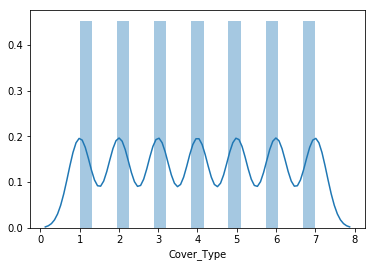

In [3]:
sns.distplot(data_train_org[y])

# Start Training

In [4]:
htrain_frame[y] = htrain_frame[y].asfactor()
hvalid_frame[y] = hvalid_frame[y].asfactor()

In [5]:
htrain_frame.types

{'Id': 'int',
 'Elevation': 'int',
 'Aspect': 'int',
 'Slope': 'int',
 'Horizontal_Distance_To_Hydrology': 'int',
 'Vertical_Distance_To_Hydrology': 'int',
 'Horizontal_Distance_To_Roadways': 'int',
 'Hillshade_9am': 'int',
 'Hillshade_Noon': 'int',
 'Hillshade_3pm': 'int',
 'Horizontal_Distance_To_Fire_Points': 'int',
 'Wilderness_Area1': 'int',
 'Wilderness_Area2': 'int',
 'Wilderness_Area3': 'int',
 'Wilderness_Area4': 'int',
 'Soil_Type1': 'int',
 'Soil_Type2': 'int',
 'Soil_Type3': 'int',
 'Soil_Type4': 'int',
 'Soil_Type5': 'int',
 'Soil_Type6': 'int',
 'Soil_Type7': 'int',
 'Soil_Type8': 'int',
 'Soil_Type9': 'int',
 'Soil_Type10': 'int',
 'Soil_Type11': 'int',
 'Soil_Type12': 'int',
 'Soil_Type13': 'int',
 'Soil_Type14': 'int',
 'Soil_Type15': 'int',
 'Soil_Type16': 'int',
 'Soil_Type17': 'int',
 'Soil_Type18': 'int',
 'Soil_Type19': 'int',
 'Soil_Type20': 'int',
 'Soil_Type21': 'int',
 'Soil_Type22': 'int',
 'Soil_Type23': 'int',
 'Soil_Type24': 'int',
 'Soil_Type25': 'int',
 

In [16]:
%%time
aml = h2o.automl.H2OAutoML(
#                             max_runtime_secs=60, 
                           max_models=1,
                           seed=42, project_name='forest_type')

aml.train(y=y, training_frame=htrain_frame, leaderboard_frame=hvalid_frame)

print(aml.leaderboard.head())
print(aml.predict(hvalid_frame.drop(y)).head())

AutoML progress: |███████ (cancelled)


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_9cb39a96703ea623298f5bd023cb4fee> was cancelled by the user.

# Predict Test Dataset

In [19]:
prediction_test_hframe = aml.predict(htest_frame)

stackedensemble prediction progress: |████████████████████████████████████| 100%


ValueError: If using all scalar values, you must pass an index

In [63]:
data_train_org[y].unique()

array([5, 2, 1, 7, 3, 6, 4])

In [68]:
print(data_train[y].unique())

[3 1 7 6 4 2 5]


In [32]:
prediction_test_hframe.as_data_frame().shape

(565892, 1)

In [27]:
type(prediction_test_hframe.as_data_frame())

pandas.core.frame.DataFrame

In [ ]:
prediction_test_hframe.as_data_frame().iloc[:, 0]

In [55]:
submission = pd.DataFrame({'ID': data_test['Id'],
                          'TARGET': prediction_test_hframe.as_data_frame().iloc[:, 0]})

submission.to_csv('./submission.csv', index=False)

In [54]:
submission.head()

,ID,TARGET
0,15121,1.375953
1,15122,1.260439
2,15123,1.456687
3,15124,1.477996
4,15125,1.479743
